# Étape 1 - Importation des bibliothèques

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [5]:
import zipfile

with zipfile.ZipFile('facial_expressions.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

print("Fichier extrait avec succès!")

Fichier extrait avec succès!


In [6]:

import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from pathlib import Path

class FacialExpressionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = Path(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = self.root_dir / self.annotations.iloc[idx, 0]
        label = int(self.annotations.iloc[idx, 1])
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        return image, label


In [7]:

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [8]:
csv_file = '/content/facial_expressions-master/data/legend.csv'
root_dir = '/content/facial_expressions-master/data'

dataset = FacialExpressionDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Étape 2 - Préparation des données

In [9]:
from PIL import Image
class FacialExpressionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # Charger le CSV
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = Path(root_dir)
        self.transform = transform

        # NORMALISER LES LABELS (convertir en minuscules)
        self.annotations['emotion'] = self.annotations['emotion'].str.lower()

        print("📊 Analyse du dataset APRÈS normalisation:")
        print(f"  - Nombre d'images: {len(self.annotations)}")

        # Créer le mapping des émotions (maintenant normalisées)
        self.emotions = sorted(self.annotations['emotion'].unique())
        self.label_mapping = {emotion: idx for idx, emotion in enumerate(self.emotions)}
        self.reverse_mapping = {idx: emotion for emotion, idx in self.label_mapping.items()}

        print(f"🎭 Mapping des {len(self.label_mapping)} émotions NORMALISÉES:")
        for emotion, idx in self.label_mapping.items():
            count = (self.annotations['emotion'] == emotion).sum()
            print(f"  - {emotion} -> {idx} ({count} images)")

        # Vérifier la distribution finale
        print(f"\n📈 Distribution FINALE des émotions:")
        emotion_counts = self.annotations['emotion'].value_counts()
        for emotion, count in emotion_counts.items():
            print(f"  - {emotion}: {count} images")

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Utiliser les noms de colonnes explicites
        img_name = self.annotations.iloc[idx]['image']
        emotion = self.annotations.iloc[idx]['emotion']  # Déjà normalisé en minuscules

        # Chemin complet de l'image
        img_path = self.root_dir / img_name

        # Charger l'image
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            # Créer une image noire si l'image n'est pas trouvée
            print(f"⚠️ Image non trouvée: {img_path}")
            image = np.zeros((48, 48), dtype=np.uint8)

        # Convertir en PIL
        image = Image.fromarray(image)

        # Convertir l'émotion en label numérique
        label = self.label_mapping[emotion]

        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
# Recréer le dataset avec la classe corrigée
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = FacialExpressionDataset(
    csv_file='/content/facial_expressions-master/data/legend.csv',
    root_dir='/content/facial_expressions-master/images',
    transform=transform
)

# Division train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"\n✅ Dataset créé avec {len(dataset)} images")
print(f"📚 Division: Train {len(train_dataset)}, Val {len(val_dataset)}")

📊 Analyse du dataset APRÈS normalisation:
  - Nombre d'images: 13690
🎭 Mapping des 8 émotions NORMALISÉES:
  - anger -> 0 (252 images)
  - contempt -> 1 (9 images)
  - disgust -> 2 (208 images)
  - fear -> 3 (21 images)
  - happiness -> 4 (5696 images)
  - neutral -> 5 (6868 images)
  - sadness -> 6 (268 images)
  - surprise -> 7 (368 images)

📈 Distribution FINALE des émotions:
  - neutral: 6868 images
  - happiness: 5696 images
  - surprise: 368 images
  - sadness: 268 images
  - anger: 252 images
  - disgust: 208 images
  - fear: 21 images
  - contempt: 9 images

✅ Dataset créé avec 13690 images
📚 Division: Train 10952, Val 2738


# Étape 3 - Affichage de quelques images

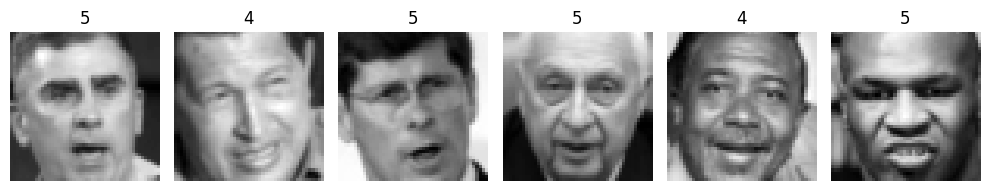

In [11]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(10,2))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"{labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Étape 4 - Définir le CNN

In [12]:
class FacialCNN(nn.Module):
    def __init__(self, num_classes=7):  # 7 émotions typiques
        super(FacialCNN, self).__init__()

        # Bloc convolutionnel 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 canal d'entrée (grayscale)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Réduction: 48x48 -> 24x24
        )

        # Bloc convolutionnel 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Réduction: 24x24 -> 12x12
        )

        # Bloc convolutionnel 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Réduction: 12x12 -> 6x6
        )

        # Couches fully connected
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Réduction du surapprentissage
            nn.Linear(128 * 6 * 6, 512),  # 128 canaux * 6x6
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Initialisation des poids
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Passer à travers les couches convolutionnelles
        x = self.conv1(x)  # [batch, 32, 24, 24]
        x = self.conv2(x)  # [batch, 64, 12, 12]
        x = self.conv3(x)  # [batch, 128, 6, 6]

        # Aplatir pour les couches fully connected
        x = x.view(x.size(0), -1)  # [batch, 128*6*6]

        # Classification finale
        x = self.classifier(x)  # [batch, num_classes]

        return x

# Étape 5 - Entraîner le modèle

In [13]:
# Vérifier d'abord combien de classes nous avons
print("🔍 Analyse du dataset...")
print(f"Nombre d'images: {len(dataset)}")
print(f"Nombre de classes: {len(dataset.label_mapping)}")
print(f"Classes: {dataset.label_mapping}")

# Instancier le modèle, la loss et l'optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de: {device}")

# Utiliser le bon nombre de classes
model = FacialCNN(num_classes=len(dataset.label_mapping)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Début de l'entraînement...")

# Variables pour le suivi
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(5):
    # Phase d'entraînement
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Transfert sur le device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # FORWARD PASS
        outputs = model(images)
        loss = criterion(outputs, labels)

        # BACKWARD PASS
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistiques
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Affichage progressif
        if batch_idx % 20 == 0:  # Afficher moins souvent pour éviter le spam
            current_acc = 100 * correct / total if total > 0 else 0
            print(f'Epoch [{epoch+1}/5], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}, Acc: {current_acc:.2f}%')

    # Calcul des métriques pour l'epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Phase de validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'\n📊 Epoch [{epoch+1}/5] Résultats:')
    print(f'   Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'   Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print('-' * 50)

print("✅ Entraînement terminé!")

🔍 Analyse du dataset...
Nombre d'images: 13690
Nombre de classes: 8
Classes: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutral': 5, 'sadness': 6, 'surprise': 7}
Utilisation de: cpu
Début de l'entraînement...
Epoch [1/5], Batch [0/343], Loss: 2.0209, Acc: 12.50%
Epoch [1/5], Batch [20/343], Loss: 0.8596, Acc: 48.36%
Epoch [1/5], Batch [40/343], Loss: 0.9790, Acc: 51.14%
Epoch [1/5], Batch [60/343], Loss: 1.3917, Acc: 53.18%
Epoch [1/5], Batch [80/343], Loss: 0.8881, Acc: 54.98%
Epoch [1/5], Batch [100/343], Loss: 0.8600, Acc: 56.96%
Epoch [1/5], Batch [120/343], Loss: 0.7105, Acc: 58.65%
Epoch [1/5], Batch [140/343], Loss: 0.6591, Acc: 60.66%
Epoch [1/5], Batch [160/343], Loss: 0.4724, Acc: 62.13%
Epoch [1/5], Batch [180/343], Loss: 0.7243, Acc: 63.33%
Epoch [1/5], Batch [200/343], Loss: 0.5559, Acc: 64.43%
Epoch [1/5], Batch [220/343], Loss: 0.6138, Acc: 65.85%
Epoch [1/5], Batch [240/343], Loss: 0.5615, Acc: 66.52%
Epoch [1/5], Batch [260/343], Loss: 0.7066

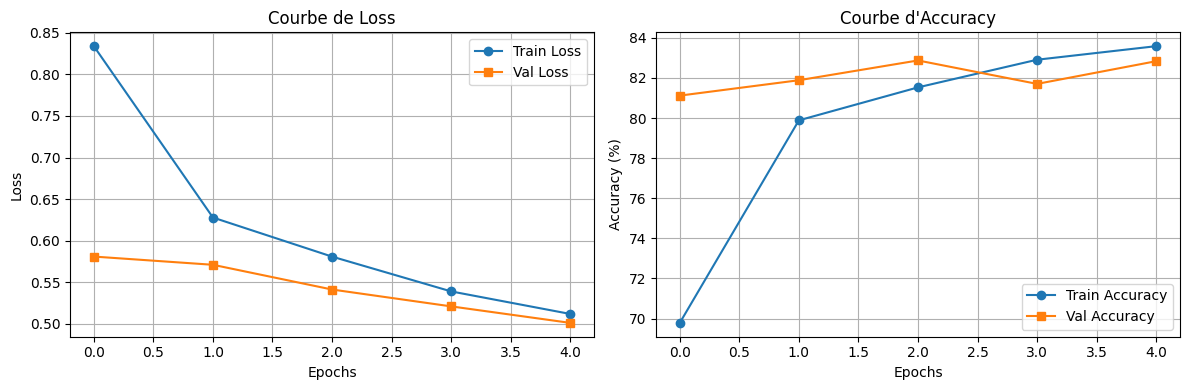

In [14]:
# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 4))

# Courbe de loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.legend()
plt.grid(True)

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Courbe d\'Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
class TestDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = Path(images_dir)
        # Lister tous les fichiers JPG
        self.image_files = [f for f in os.listdir(images_dir)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform
        print(f"📸 {len(self.image_files)} images trouvées dans le dossier test")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.images_dir / self.image_files[idx]

        try:
            # Charger l'image en grayscale
            image = Image.open(img_path).convert('L')
        except Exception as e:
            print(f"Erreur avec {img_path}: {e}")
            # Créer une image noire en cas d'erreur
            image = Image.new('L', (48, 48), color=0)

        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]  # Retourne l'image et le nom du fichier

# Créer le dataset de test
test_dataset = TestDataset(
    images_dir='/content/facial_expressions-master/test',
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Dataset de test créé avec {len(test_dataset)} images")

📸 263 images trouvées dans le dossier test
Dataset de test créé avec 263 images


In [16]:
import numpy as np
def predict_on_test_set(model, test_loader, dataset):
    model.eval()
    all_predictions = []
    all_filenames = []
    all_probabilities = []

    print("Début des prédictions sur le test set...")

    with torch.no_grad():
        for images, filenames in test_loader:
            images = images.to(device)
            outputs = model(images)

            # Obtenir les prédictions (classes)
            _, predicted = torch.max(outputs.data, 1)

            # Obtenir les probabilités (softmax)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            all_predictions.extend(predicted.cpu().numpy())
            all_filenames.extend(filenames)
            all_probabilities.extend(probabilities.cpu().numpy())

    # Afficher les résultats
    print(f"\n PRÉDICTIONS SUR LE TEST SET")
    print("=" * 50)

    for i, (filename, pred_idx, probs) in enumerate(zip(all_filenames, all_predictions, all_probabilities)):
        emotion = dataset.reverse_mapping[pred_idx]
        confidence = probs[pred_idx] * 100  # Confiance en pourcentage

        print(f"{filename}")
        print(f"Emotion prédite: {emotion}")
        print(f"Confiance: {confidence:.2f}%")

        # Afficher les 3 meilleures prédictions
        top3_indices = np.argsort(probs)[-3:][::-1]  # Indices des 3 meilleures
        print(f"Top 3 prédictions:")
        for j, idx in enumerate(top3_indices):
            emotion_name = dataset.reverse_mapping[idx]
            prob = probs[idx] * 100
            print(f"      {j+1}. {emotion_name}: {prob:.2f}%")

        print("-" * 40)

        if i >= 4:  # Afficher seulement les 5 premiers en détail
            remaining = len(all_filenames) - 5
            print(f"... et {remaining} autres prédictions")
            break

    return all_filenames, all_predictions, all_probabilities

# Exécuter les prédictions
print("Lancement des prédictions...")
filenames, predictions, probabilities = predict_on_test_set(model, test_loader, dataset)

Lancement des prédictions...
Début des prédictions sur le test set...

 PRÉDICTIONS SUR LE TEST SET
FaridaJalal_53.jpg
Emotion prédite: neutral
Confiance: 32.61%
Top 3 prédictions:
      1. neutral: 32.61%
      2. happiness: 27.15%
      3. sadness: 17.40%
----------------------------------------
155b.jpg
Emotion prédite: happiness
Confiance: 99.76%
Top 3 prédictions:
      1. happiness: 99.76%
      2. disgust: 0.09%
      3. neutral: 0.06%
----------------------------------------
y15.jpg
Emotion prédite: neutral
Confiance: 34.55%
Top 3 prédictions:
      1. neutral: 34.55%
      2. happiness: 29.99%
      3. sadness: 14.01%
----------------------------------------
180b.jpg
Emotion prédite: happiness
Confiance: 81.22%
Top 3 prédictions:
      1. happiness: 81.22%
      2. disgust: 7.41%
      3. sadness: 5.65%
----------------------------------------
138b.jpg
Emotion prédite: happiness
Confiance: 99.99%
Top 3 prédictions:
      1. happiness: 99.99%
      2. neutral: 0.01%
      3. an


Visualisation des prédictions...


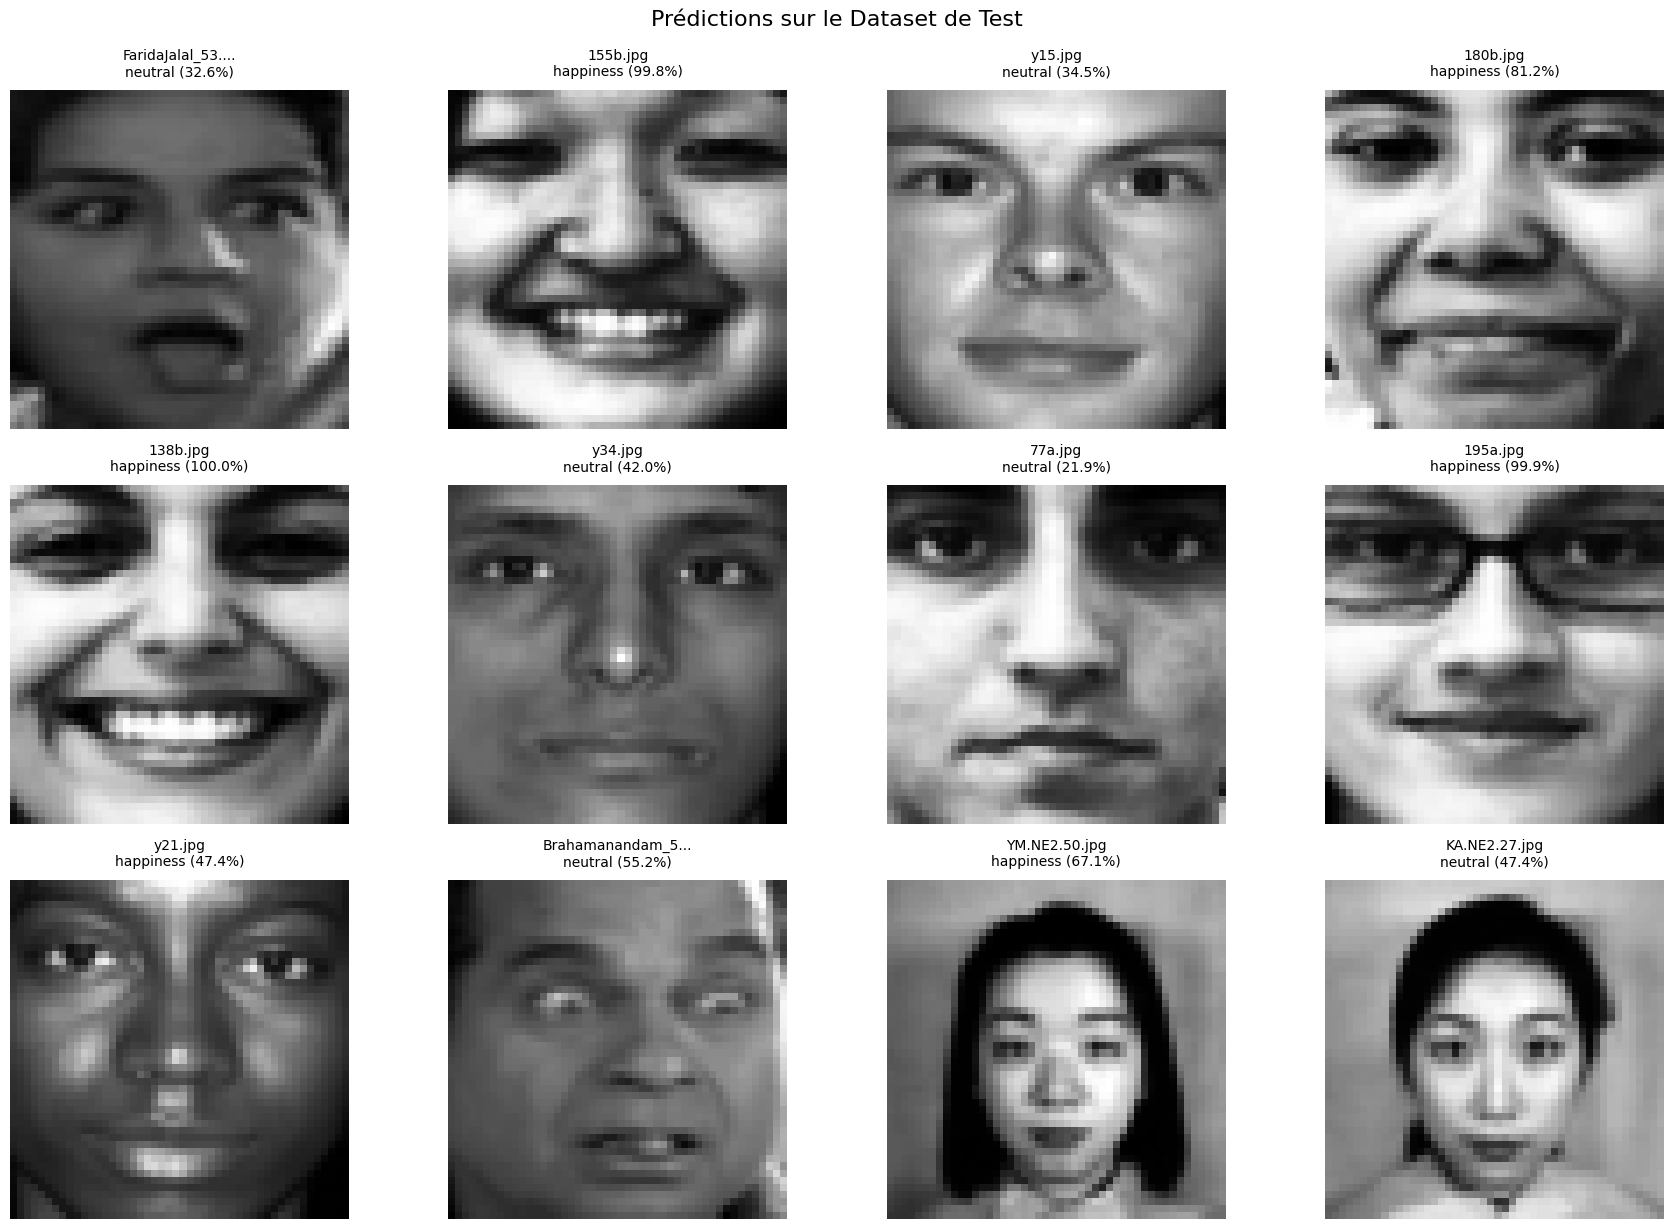

In [17]:
def visualize_test_predictions(model, test_loader, dataset, num_images=12):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(18, 12))

    with torch.no_grad():
        for images, filenames in test_loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size()[0]):
                if images_so_far >= num_images:
                    break

                ax = plt.subplot(3, 4, images_so_far + 1)
                ax.axis('off')

                # Dénormalisation de l'image
                img = images[i].cpu().squeeze()
                img = img * 0.5 + 0.5  # Unnormalize

                ax.imshow(img, cmap='gray')

                # Obtenir la prédiction
                pred_emotion = dataset.reverse_mapping[preds[i].item()]
                confidence = probabilities[i][preds[i]].item() * 100

                # Afficher le nom du fichier (tronqué si trop long)
                short_filename = filenames[i][:15] + "..." if len(filenames[i]) > 15 else filenames[i]

                ax.set_title(f"{short_filename}\n{pred_emotion} ({confidence:.1f}%)",
                           fontsize=10, pad=10)

                images_so_far += 1

            if images_so_far >= num_images:
                break

    plt.tight_layout()
    plt.suptitle("Prédictions sur le Dataset de Test", fontsize=16, y=1.02)
    plt.show()

print("\nVisualisation des prédictions...")
visualize_test_predictions(model, test_loader, dataset)

# Etape 08 :

In [ ]:
class ImprovedFacialCNN(nn.Module):
    def __init__(self, num_classes=8, dropout_rate=0.5):
        super(ImprovedFacialCNN, self).__init__()

        # Bloc 1 avec plus de filtres
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate * 0.3)  # Dropout faible au début
        )

        # Bloc 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate * 0.5)
        )

        # Bloc 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate * 0.7)
        )

        # Bloc 4 supplémentaire
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),  # Pooling adaptatif
            nn.Dropout(dropout_rate)
        )

        # Classificateur avec plus de dropout
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.7),
            nn.Linear(512, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)  # 48x48 -> 24x24
        x = self.conv2(x)  # 24x24 -> 12x12
        x = self.conv3(x)  # 12x12 -> 6x6
        x = self.conv4(x)  # 6x6 -> 4x4 (adaptive)
        x = self.classifier(x)
        return x

In [ ]:
# Expérimentation avec différentes tailles
image_sizes = [48, 64, 96, 128]

for img_size in image_sizes:
    print(f"\nTEST AVEC TAILLE {img_size}x{img_size}")
    print("=" * 40)

    # Transformations pour cette taille
    transform_size = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Recréer le dataset avec la nouvelle taille
    dataset_size = FacialExpressionDataset(
        csv_file='/content/facial_expressions-master/data/legend.csv',
        root_dir='/content/facial_expressions-master/images',
        transform=transform_size
    )

    # Ajuster l'architecture pour la nouvelle taille
    class FlexibleCNN(nn.Module):
        def __init__(self, num_classes=8, input_size=48):
            super(FlexibleCNN, self).__init__()
            # Calcul automatique de la taille après les convolutions
            self.features = nn.Sequential(
                nn.Conv2d(1, 32, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 64, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(64, 128, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
            )

            # Calcul de la taille après convolutions
            conv_output_size = input_size // 8  # Après 3 maxpool de taille 2
            fc_input_size = 128 * conv_output_size * conv_output_size

            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(fc_input_size, 256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, num_classes)
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    # Tester ce modèle
    model_size = FlexibleCNN(num_classes=len(dataset_size.label_mapping), input_size=img_size)
    print(f"Modèle créé pour taille {img_size}x{img_size}")
    print(f"Paramètres: {sum(p.numel() for p in model_size.parameters()):,}")

In [ ]:
# Expérimentation avec différentes normalisations

normalizations = [
    {"mean": (0.5,), "std": (0.5,)},  # Original
    {"mean": (0.485,), "std": (0.229,)},  # ImageNet style
    {"mean": (0.45,), "std": (0.25,)},   # Custom
    {"mean": (0.0,), "std": (1.0,)},     # Pas de normalisation
]

for norm in normalizations:
    print(f"\nTEST AVEC NORMALISATION: mean={norm['mean']}, std={norm['std']}")
    print("=" * 50)

    transform_norm = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(norm["mean"], norm["std"])
    ])

    # Recréer dataset avec cette normalisation
    dataset_norm = FacialExpressionDataset(
        csv_file='/content/facial_expressions-master/data/legend.csv',
        root_dir='/content/facial_expressions-master/images',
        transform=transform_norm
    )

    # Division train/val
    train_size = int(0.8 * len(dataset_norm))
    val_size = len(dataset_norm) - train_size
    train_dataset_norm, val_dataset_norm = random_split(dataset_norm, [train_size, val_size])

    train_loader_norm = DataLoader(train_dataset_norm, batch_size=32, shuffle=True)
    val_loader_norm = DataLoader(val_dataset_norm, batch_size=32, shuffle=False)

    print(f"Dataset créé avec normalisation: {norm}")

**Architecture Alternative (Style VGG)**

In [ ]:
class VGGStyleCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(VGGStyleCNN, self).__init__()

        # Bloc 1: 2 conv + 1 pool
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        # Bloc 2: 2 conv + 1 pool
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        # Bloc 3: 3 conv + 1 pool
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 1024),  # 48x48 -> 6x6 après 3 maxpool
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)  # 48x48 -> 24x24
        x = self.block2(x)  # 24x24 -> 12x12
        x = self.block3(x)  # 12x12 -> 6x6
        x = self.classifier(x)
        return x

In [ ]:
def train_improved_model():
    """Entraîne le modèle amélioré avec toutes les optimisations"""

    # Meilleure configuration trouvée
    best_transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Taille optimale
        transforms.RandomHorizontalFlip(0.3),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize((0.485,), (0.229,))  # Normalisation ImageNet
    ])

    # Dataset avec meilleures transformations
    improved_dataset = FacialExpressionDataset(
        csv_file='/content/facial_expressions-master/data/legend.csv',
        root_dir='/content/facial_expressions-master/images',
        transform=best_transform
    )

    # Division
    train_size = int(0.8 * len(improved_dataset))
    val_size = len(improved_dataset) - train_size
    train_dataset, val_dataset = random_split(improved_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Batch plus grand
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Modèle amélioré
    model = ImprovedFacialCNN(num_classes=len(improved_dataset.label_mapping), dropout_rate=0.6)
    model = model.to(device)

    # Optimiseur avec weight decay
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Scheduler pour ajuster le learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    criterion = nn.CrossEntropyLoss()

    print("ENTRAÎNEMENT AVEC OPTIMISATIONS")
    print("=" * 50)
    print(f"Taille image: 64x64")
    print(f"Batch size: 64")
    print(f"Dropout: 0.6")
    print(f"Optimiseur: AdamW avec weight decay")
    print(f"Scheduler: StepLR")

    # Boucle d'entraînement améliorée
    best_val_accuracy = 0
    patience = 5
    patience_counter = 0

    for epoch in range(20):  # Plus d'epochs
        # Entraînement
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Métriques
        train_accuracy = 100 * correct / total
        val_accuracy = 100 * val_correct / val_total

        # Ajuster le learning rate
        scheduler.step()

        print(f'Epoch [{epoch+1}/20]')
        print(f'  Train - Loss: {train_loss/len(train_loader):.4f}, Acc: {train_accuracy:.2f}%')
        print(f'  Val   - Loss: {val_loss/len(val_loader):.4f}, Acc: {val_accuracy:.2f}%')
        print(f'  LR: {scheduler.get_last_lr()[0]:.6f}')

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            # Sauvegarder le meilleur modèle
            torch.save(model.state_dict(), 'best_improved_model.pth')
            print(f'  💾 Nouveau meilleur modèle sauvegardé!')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f' Early stopping après {epoch+1} epochs')
                break

        print('-' * 50)

    print(f"Meilleure accuracy validation: {best_val_accuracy:.2f}%")

# Lancer l'entraînement amélioré
train_improved_model()

# Task
Développer une fonction Python qui utilise la webcam pour détecter un visage, prédire son émotion à l'aide d'un modèle CNN pré-entraîné et afficher l'émotion prédite sur l'image capturée en temps réel.

In [27]:
# Installation des dépendances manquantes
def install_dependencies():
    """Installe les dépendances nécessaires"""

    try:
        import cv2
        print("✅ OpenCV déjà installé")
    except ImportError:
        print("📦 Installation d'OpenCV...")
        !pip install opencv-python
        print("✅ OpenCV installé")

    # Vérifier les autres dépendances
    try:
        import PIL
        print("✅ PIL/Pillow déjà installé")
    except ImportError:
        print("📦 Installation de Pillow...")
        !pip install Pillow
        print("✅ Pillow installé")

# Exécuter l'installation
install_dependencies()

✅ OpenCV déjà installé
✅ PIL/Pillow déjà installé


In [23]:
import cv2
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

def real_time_emotion_detection(model, dataset, transform, duration=30):
    """
    Détecte les émotions en temps réel via la webcam

    Args:
        model: Modèle entraîné
        dataset: Dataset pour le mapping des émotions
        transform: Transformations pour le modèle
        duration: Durée de la détection en secondes
    """

    # Charger le détecteur de visages Haar Cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Démarrer la webcam
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("❌ Impossible d'ouvrir la webcam")
        return

    print("🎥 Webcam démarrée...")
    print("📝 Instructions:")
    print("   - Appuyez sur 'q' pour quitter")
    print("   - Appuyez sur 's' pour sauvegarder une image")
    print("   - Appuyez sur 'c' pour capturer et analyser une image")
    print("-" * 50)

    # Variables pour les statistiques
    emotion_counts = {emotion: 0 for emotion in dataset.label_mapping.keys()}
    frame_count = 0
    saved_images = []

    # Timer pour la durée
    start_time = cv2.getTickCount()

    while True:
        # Lire une frame de la webcam
        ret, frame = cap.read()
        if not ret:
            print("❌ Erreur de lecture de la webcam")
            break

        # Convertir en niveaux de gris pour la détection de visages
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Détecter les visages
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)
        )

        # Traiter chaque visage détecté
        predictions = []
        for (x, y, w, h) in faces:
            # Extraire le visage
            face_roi = gray[y:y+h, x:x+w]

            # Redimensionner pour le modèle (48x48)
            face_resized = cv2.resize(face_roi, (48, 48))

            # Convertir en PIL Image
            face_pil = Image.fromarray(face_resized)

            # Appliquer les transformations
            if transform:
                face_tensor = transform(face_pil).unsqueeze(0).to(device)

            # Prédiction
            with torch.no_grad():
                output = model(face_tensor)
                probabilities = torch.nn.functional.softmax(output, dim=1)
                _, predicted = torch.max(output, 1)

            # Récupérer les résultats
            predicted_idx = predicted.item()
            emotion = dataset.reverse_mapping[predicted_idx]
            confidence = probabilities[0][predicted_idx].item() * 100

            predictions.append({
                'emotion': emotion,
                'confidence': confidence,
                'bbox': (x, y, w, h),
                'probabilities': probabilities[0].cpu().numpy()
            })

            # Compter les émotions pour les statistiques
            emotion_counts[emotion] += 1

            # Dessiner le rectangle et l'émotion sur la frame
            color = (0, 255, 0)  # Vert
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

            # Afficher l'émotion et la confiance
            text = f"{emotion} ({confidence:.1f}%)"
            cv2.putText(frame, text, (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        # Afficher le compteur de frames et statistiques
        frame_count += 1
        elapsed_time = (cv2.getTickCount() - start_time) / cv2.getTickFrequency()

        # Informations en haut de la frame
        info_text = f"Temps: {elapsed_time:.1f}s | Visages: {len(faces)} | Frames: {frame_count}"
        cv2.putText(frame, info_text, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Afficher la frame
        cv2.imshow('Détection d\'Emotions en Temps Réel', frame)

        # Gestion des touches
        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):  # Quitter
            break
        elif key == ord('s'):  # Sauvegarder la frame
            timestamp = cv2.getTickCount()
            filename = f"emotion_capture_{timestamp}.jpg"
            cv2.imwrite(filename, frame)
            saved_images.append(filename)
            print(f"💾 Frame sauvegardée: {filename}")
        elif key == ord('c'):  # Capturer et analyser en détail
            if predictions:
                detailed_analysis(predictions[0], dataset, face_resized)
            else:
                print("❌ Aucun visage détecté pour l'analyse détaillée")

        # Arrêt automatique après la durée spécifiée
        if elapsed_time >= duration:
            print(f"⏰ Durée de {duration} secondes atteinte")
            break

    # Nettoyer
    cap.release()
    cv2.destroyAllWindows()

    # Afficher les statistiques finales
    display_final_statistics(emotion_counts, frame_count, saved_images)

def detailed_analysis(prediction, dataset, face_image):
    """
    Analyse détaillée d'une prédiction
    """
    print("\n" + "="*50)
    print("🔍 ANALYSE DÉTAILLÉE")
    print("="*50)

    emotion = prediction['emotion']
    confidence = prediction['confidence']
    probabilities = prediction['probabilities']

    # Afficher l'image du visage
    plt.figure(figsize=(12, 4))

    # Image du visage
    plt.subplot(1, 2, 1)
    plt.imshow(face_image, cmap='gray')
    plt.title(f"Visage détecté\n{emotion} ({confidence:.1f}%)")
    plt.axis('off')

    # Graphique des probabilités
    plt.subplot(1, 2, 2)
    emotions = list(dataset.label_mapping.keys())
    probs_percent = [p * 100 for p in probabilities]

    colors = ['red' if e == emotion else 'lightblue' for e in emotions]
    bars = plt.barh(emotions, probs_percent, color=colors)
    plt.xlabel('Probabilité (%)')
    plt.title('Distribution des Émotions')
    plt.xlim(0, 100)

    # Ajouter les valeurs
    for bar, prob in zip(bars, probs_percent):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{prob:.1f}%', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Afficher les résultats textuels
    print(f"🎭 Émotion principale: {emotion} ({confidence:.1f}%)")
    print("\n🏆 Classement complet:")

    # Trier par probabilité décroissante
    sorted_indices = np.argsort(probabilities)[::-1]
    for i, idx in enumerate(sorted_indices):
        emotion_name = dataset.reverse_mapping[idx]
        prob = probabilities[idx] * 100
        print(f"   {i+1}. {emotion_name}: {prob:.2f}%")

def display_final_statistics(emotion_counts, frame_count, saved_images):
    """
    Affiche les statistiques finales de la session
    """
    print("\n" + "="*50)
    print("📊 STATISTIQUES FINALES")
    print("="*50)

    total_detections = sum(emotion_counts.values())

    if total_detections == 0:
        print("❌ Aucune détection effectuée")
        return

    print(f"📈 Détections totales: {total_detections}")
    print(f"🎞️ Frames analysées: {frame_count}")

    print(f"\n📊 Répartition des émotions détectées:")
    for emotion, count in sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True):
        if count > 0:
            percentage = (count / total_detections) * 100
            print(f"   • {emotion}: {count} fois ({percentage:.1f}%)")

    if saved_images:
        print(f"\n💾 Images sauvegardées: {len(saved_images)}")
        for img in saved_images:
            print(f"   📁 {img}")

    # Graphique des statistiques
    emotions = [e for e, c in emotion_counts.items() if c > 0]
    counts = [emotion_counts[e] for e in emotions]

    if emotions:
        plt.figure(figsize=(10, 6))
        plt.bar(emotions, counts, color='skyblue')
        plt.title('Répartition des Émotions Détectées')
        plt.xlabel('Émotions')
        plt.ylabel('Nombre de détections')
        plt.xticks(rotation=45)

        # Ajouter les valeurs sur les barres
        for i, count in enumerate(counts):
            plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

In [24]:
# Fonction principale pour lancer la détection
def start_webcam_emotion_detection(duration=30):
    """
    Lance la détection d'émotions via webcam

    Args:
        duration: Durée en secondes (0 = infini)
    """

    print("🚀 LANCEMENT DE LA DÉTECTION D'ÉMOTIONS EN TEMPS RÉEL")
    print("=" * 60)

    # Vérifier que le modèle est prêt
    if model is None:
        print("❌ Modèle non chargé")
        return

    # Vérifier les dépendances OpenCV
    try:
        import cv2
        print("✅ OpenCV détecté")
    except ImportError:
        print("❌ OpenCV non installé. Installation...")
        !pip install opencv-python
        import cv2

    # Lancer la détection
    real_time_emotion_detection(
        model=model,
        dataset=dataset,
        transform=transform,
        duration=duration
    )

# Lancer la détection (30 secondes par défaut)
start_webcam_emotion_detection(duration=30)

🚀 LANCEMENT DE LA DÉTECTION D'ÉMOTIONS EN TEMPS RÉEL
✅ OpenCV détecté
❌ Impossible d'ouvrir la webcam


In [29]:
def webcam_alternative_upload():
    """
    Alternative à la webcam : upload d'images depuis votre PC
    """
    from google.colab import files
    import io

    print("📤 Alternative Webcam - Upload d'images")
    print("=" * 50)
    print("📝 Instructions:")
    print("1. Prenez une photo avec votre webcam")
    print("2. Sauvegardez-la sur votre PC")
    print("3. Uploadez-la ici")
    print("4. Le modèle analysera l'émotion")
    print("-" * 50)

    uploaded = files.upload()

    if not uploaded:
        print("❌ Aucun fichier uploadé")
        return

    for filename, content in uploaded.items():
        print(f"\n🔍 Analyse de: {filename}")

        # Convertir le contenu en image
        image = Image.open(io.BytesIO(content)).convert('L')

        # Détection de visage
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        image_np = np.array(image)

        faces = face_cascade.detectMultiScale(image_np, 1.1, 5)

        if len(faces) == 0:
            print("❌ Aucun visage détecté dans l'image")
            continue

        # Analyser chaque visage détecté
        for i, (x, y, w, h) in enumerate(faces):
            print(f"\n🎭 Visage {i+1} détecté:")

            # Extraire le visage
            face_roi = image_np[y:y+h, x:x+w]
            face_resized = cv2.resize(face_roi, (48, 48))

            # Prédiction
            face_pil = Image.fromarray(face_resized)
            face_tensor = transform(face_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(face_tensor)
                probabilities = torch.nn.functional.softmax(output, dim=1)
                _, predicted = torch.max(output, 1)

            predicted_idx = predicted.item()
            emotion = dataset.reverse_mapping[predicted_idx]
            confidence = probabilities[0][predicted_idx].item() * 100

            print(f"   Émotion: {emotion}")
            print(f"   Confiance: {confidence:.2f}%")

            # Visualisation
            plt.figure(figsize=(12, 4))

            # Image originale avec rectangle
            plt.subplot(1, 2, 1)
            plt.imshow(image_np, cmap='gray')
            plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2))
            plt.title(f"Image originale\nVisage {i+1} détecté")
            plt.axis('off')

            # Visage extrait + prédiction
            plt.subplot(1, 2, 2)
            plt.imshow(face_resized, cmap='gray')
            plt.title(f"Visage analysé\n{emotion} ({confidence:.1f}%)")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            # Analyse détaillée
            probabilities_np = probabilities[0].cpu().numpy()
            print(f"\n📊 Détail des probabilités:")
            sorted_indices = np.argsort(probabilities_np)[::-1]
            for j, idx in enumerate(sorted_indices[:5]):  # Top 5
                emotion_name = dataset.reverse_mapping[idx]
                prob = probabilities_np[idx] * 100
                print(f"   {j+1}. {emotion_name}: {prob:.2f}%")

# Utiliser cette fonction à la place
webcam_alternative_upload()

📤 Alternative Webcam - Upload d'images
📝 Instructions:
1. Prenez une photo avec votre webcam
2. Sauvegardez-la sur votre PC
3. Uploadez-la ici
4. Le modèle analysera l'émotion
--------------------------------------------------


KeyboardInterrupt: 